In [140]:
import h5py
import numpy as np
from tqdm import tqdm
from pathlib import Path
from scipy.stats import norm
from utils.plot_utils import *
import matplotlib.pyplot as plt
from astropy import units, constants
from scipy.interpolate import griddata

In [2]:
from julia import Main

In [3]:
Main.eval("Threads.nthreads()")

10

## Phase Modulation

In [4]:
def phase_modulation(t, β, ω):
    return np.exp(1j*β*np.sin(ω*t))

In [5]:
Γ = 1/(100e-9)
β = 2.2
ωphase = 2*np.pi * 1.6e6 # 1.6 MHz
t = np.linspace(0,100e-6, 6001)
s = phase_modulation(t,β,ωphase)

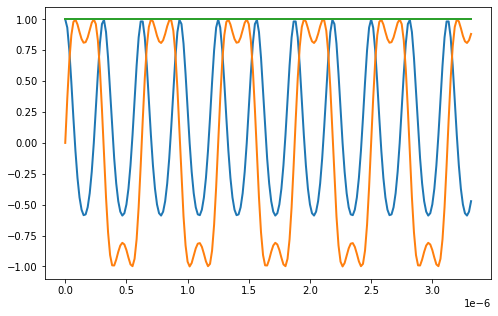

In [6]:
fig, ax = plt.subplots(figsize = (8,5))
m = np.s_[:200]
ax.plot(t[m], s.real[m], lw = 2)
ax.plot(t[m], s.imag[m], lw = 2)
ax.plot(t[m], np.abs(s[m]), lw = 2)

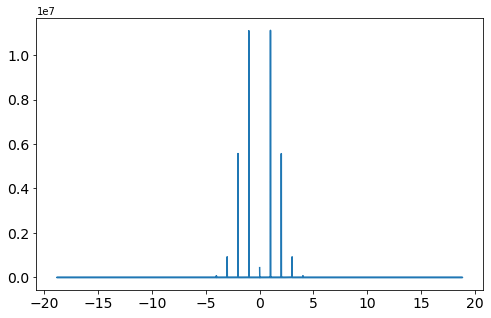

In [7]:
fourier_transform = np.fft.fft(s)
fftfreq = np.fft.fftfreq(len(fourier_transform), np.diff(t)[0])

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(fftfreq*2*np.pi/Γ, np.abs(fourier_transform**2))
set_fontsize(ax, 14)

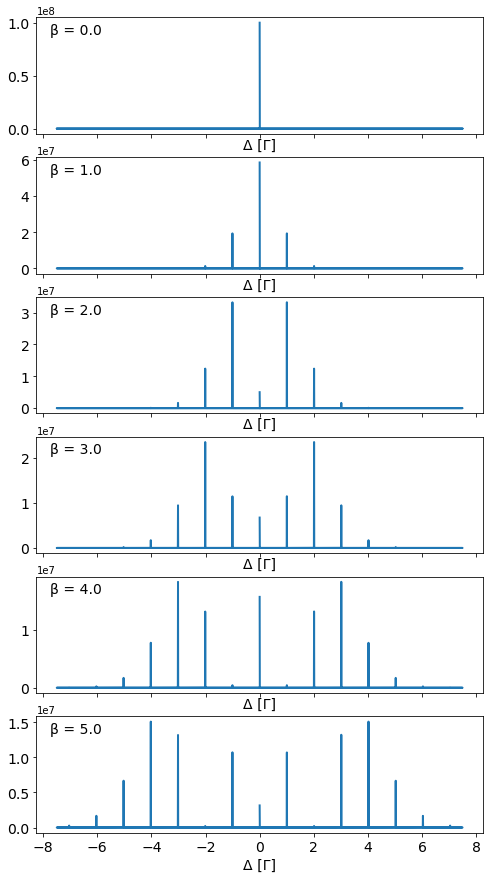

In [8]:
betas = [0,1,2,3,4,5]
fig, axes = plt.subplots(len(betas), figsize = (8,15), sharex = True)

for idx, β in enumerate(betas):
    t = np.linspace(0,100e-6, 10001)
    s = phase_modulation(t,β,ωphase)
    
    fourier_transform = np.fft.fft(s)
    fftfreq = np.fft.fftfreq(len(fourier_transform), np.diff(t)[0])
    fftfreq *= 2*np.pi
    m = np.abs(fftfreq/Γ) < 7.5

    axes[idx].plot(fftfreq[m]/Γ, np.abs(fourier_transform**2)[m], lw = 2)
    
    axes[idx].text(0.03, 0.95, f"β = {β:.1f}", transform = axes[idx].transAxes,
        ha = 'left', va = 'top', fontsize = 14);
    
    axes[idx].set_xlabel("Δ [Γ]")
    
    set_fontsize(axes[idx], 14)

## Velocity Broadening
The beamsource can be modelled as an extended source, spawning molecules in a 2D gaussian distribution with width $\sigma = 4.83 mm$ at 1 cm from the cell opening.  
From Oskari's beamsource characterization report the forward velocity is 184 m/s $\pm$ 16.8 m/s, width a transverse velocity $\sigma_\perp = 93/2\sqrt{2}\log{2}$ m/s.  

The Doppler shift in frequency is given by $f = f_0 \left(1+v/c\right)$, where $f_0$ is the rest frequency.

In [9]:
@units.quantity_input
def doppler_shift(v: units.m/units.s, frequency: units.Hz):
    return (frequency*(1+v/constants.c)).to(units.Hz)

In [10]:
Γ = (1/(100*units.ns)).to(units.Hz)
vp = 1*units.m/units.s
ω = (2*np.pi*constants.c/(271*units.nm)).to(units.Hz)

In [11]:
v_to_Γ = (doppler_shift(vp,ω) - ω)/Γ
print(f'1 m/s transverse velocity results in a frequency shift of {v_to_Γ:.2f} Γ')

1 m/s transverse velocity results in a frequency shift of 2.32 Γ


The rotational cooling detection scheme has 2 apertures with a radius of 4 mm, one placed before the rotational cooling chamber and another before the detection chamber.

Now spawning the molecules with random positions and velocities, drawn from gaussian distributions.

In [12]:
# from Oskari's Beam Characterization report
vcm = 184
vcm_sigma = 16.8
vt_sigma = 93/(2*np.sqrt(2*np.log(2))) # from FWHM

# coordinate width, adapted from ACME to CeNTREX based on email from Xing Wu on 6-10-2020
sigma_width = 0.25*25.4/5 * 3.8e-3

v_acceptable = 1.5 # m/s

v_laser = 1.5 # m/s, molecules the laser can interact with
r_laser = 5e-3 # m

In [13]:
generate_random_r = lambda x: np.random.normal(0,sigma_width,x)
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, vcm_sigma, x)

def generate_random_coords(size):
    xy = np.empty([2,size])
    xy[0,:] = generate_random_r(size)
    xy[1,:] = generate_random_r(size)
    return xy
            
def generate_random_transverse_velocities(size):
    v_transverse = np.random.multivariate_normal([0,0],np.array([[vt_sigma**2,0],[0,vt_sigma**2]]),size).T
    return v_transverse

In [14]:
size = int(1e7)
coords = generate_random_coords(size)
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

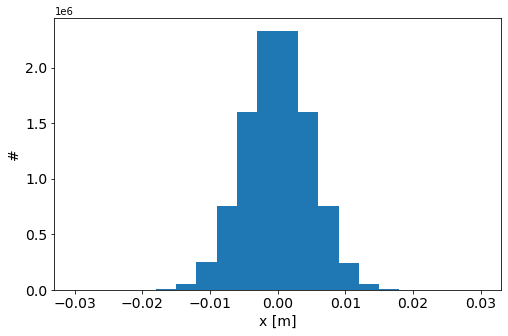

In [15]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(coords[0,:], bins = np.linspace(-0.03, 0.03, 21))
ax.set_xlabel('x [m]')
ax.set_ylabel('#')

set_fontsize(ax, 14)

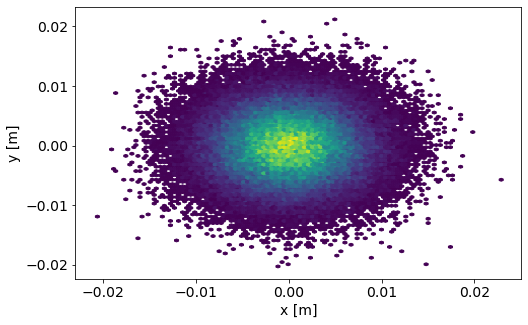

In [16]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(coords[0,:][:int(1e5)],coords[1,:][:int(1e5)], mincnt = 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

set_fontsize(ax, 14)

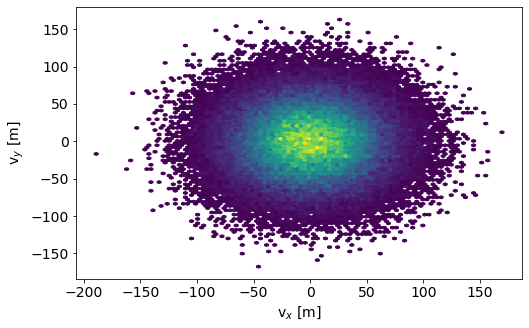

In [17]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(v_x[:int(1e5)], v_y[:int(1e5)], mincnt = 1)
ax.set_xlabel(r'v$_x$ [m]')
ax.set_ylabel(r'v$_y$ [m]')

set_fontsize(ax, 14)

### Without Aperture
Without an aperture there are several transverse velocity limiting components in the beamline.  
The closest to the rotational cooling chamber is the entrance flange, where the 1st colimator would also be placed.
The distance from the assumed extended source of this component is 17.36" - 1 cm, and the opening diameter is 60 mm.

In [18]:
in_to_m = (units.imperial.inch).to(units.m)

In [19]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

filtered = np.empty([3,size])

dt = distance_aperture_1/v_z
filtered[0,:] = coords[0,:]+dt*v_x
filtered[1,:] = coords[1,:]+dt*v_y
filtered[2,:] = distance_aperture_1

m = np.sqrt(np.sum(filtered[:2,:]**2, axis = 0)) < 60/2 * 1e-3
size = m.sum()

v_x_full, v_y_full, v_z_full = v_x.copy(), v_y.copy(), v_z.copy()
v_x, v_y, v_z = v_x[m], v_y[m], v_z[m]

coords_full = coords.copy()
coords = np.empty([2,size])
coords[0,:] = coords_full[0,:][m]
coords[1,:] = coords_full[1,:][m]

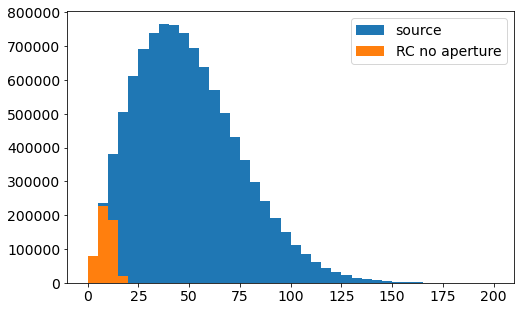

In [20]:
dx = 5
b = np.arange(0,200+dx,dx)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.sqrt(v_x_full**2+v_y_full**2), bins = b, label = 'source')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = b, label = 'RC no aperture')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

distance to RC laser from cell opening is 21.75"  
distance to aperture #1 from cell opening is 17.36"  

distance to LIF laser from cell opening is 38.39"  
distance to aperture #2 from cel opening is 35.37" 

In [21]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

coords_aperture_1 = np.empty([3,size])

dt = distance_aperture_1/v_z
coords_aperture_1[0,:] = coords[0,:]+dt*v_x
coords_aperture_1[1,:] = coords[1,:]+dt*v_y
coords_aperture_1[2,:] = distance_aperture_1

In [22]:
distance_aperture_2 = 35.37 * in_to_m - 0.01

coords_aperture_2 = np.empty([3,size])

dt = distance_aperture_2/v_z
coords_aperture_2[0,:] = coords[0,:]+dt*v_x
coords_aperture_2[1,:] = coords[1,:]+dt*v_y
coords_aperture_2[2,:] = distance_aperture_2

In [23]:
distance_laser_rc = 21.75 * in_to_m - 0.01
dt = distance_laser_rc/v_z

m_interaction_rc = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_rc = np.sum(m_interaction_rc)

In [24]:
distance_laser_lif = 38.30 * in_to_m - 0.01
dt = distance_laser_lif/v_z

m_iteraction_lif = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_lif = np.sum(m_iteraction_lif)

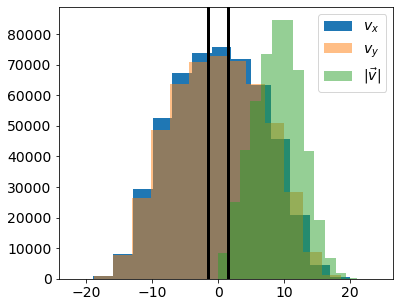

In [25]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$')
ax.hist(v_y, bins = bins, alpha = 0.5, label = r'$v_y$')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = bins, alpha = 0.5, label = r'$|\vec{v}|$')

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

This figure shows the transverse velocity spread in the rotational cooling chamber.

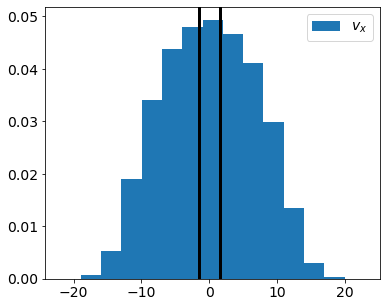

In [26]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$', density=True)

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

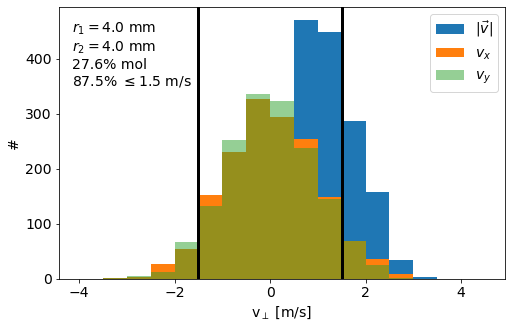

In [27]:
# calculating the velocity spread after 2 apertures
# both with an aperture radius of 4 mm

r1 = 4e-3
r2 = 4e-3

bins = np.arange(-4,4+1,0.5)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
ax.hist(v_x[m], bins = bins, label = r'$v_x$')
ax.hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$')

ax.legend(fontsize = 14, loc = 1)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')

ax.set_xlabel(r'v$_\perp$ [m/s]')
ax.set_ylabel('#')

set_fontsize(ax, 14)
    
dt = distance_laser_lif/v_z[m]
m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
interact = m_interact.sum()/interaction_lif*100

text = f'$r_1 = ${r1*1e3:.1f} mm'+'\n'
text += f'$r_2 = ${r2*1e3:.1f} mm'+'\n'
text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
text += f'{(100*(np.abs(v_x[m]) < v_acceptable).sum()/m.sum()):.1f}% $\leq {v_acceptable}$ m/s'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

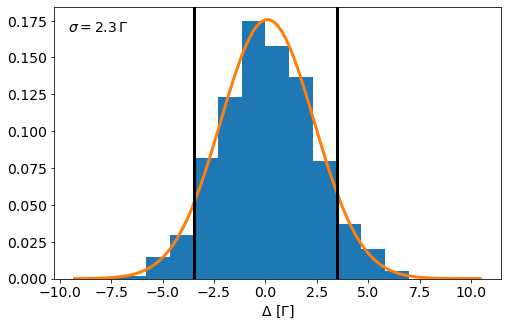

In [28]:
bins = np.arange(-4*v_to_Γ,(4+1)*v_to_Γ,0.5*v_to_Γ)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(v_x[m]*v_to_Γ, bins = bins, label = r'$v_x$', density = True)

mu, sigma = norm.fit(v_x[m]*v_to_Γ)

_x = np.linspace(bins.min(), bins.max(), 101)
ax.plot(_x, norm.pdf(_x, mu, sigma), lw = 3)

ax.axvline(v_acceptable*v_to_Γ, lw = 3, color = 'k')
ax.axvline(-v_acceptable*v_to_Γ, lw = 3, color = 'k')

ax.set_xlabel(r'$\Delta$ [Γ]')
set_fontsize(ax, 14)

text = f'$\sigma = ${sigma:.1f}$\,$Γ'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

The transverse velocity spread that makes it to the LIF detection region in units of $\Gamma$.

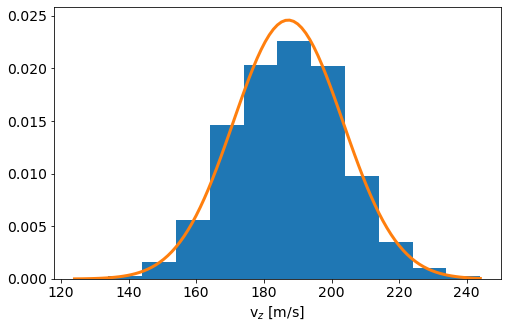

In [29]:
bins = np.linspace(184-60, 184+60, 13)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(v_z[m], density = True, bins = bins)


mu_z, sigma_z = norm.fit(v_z[m])

_z = np.linspace(bins.min(), bins.max(), 101)
ax.plot(_z, norm.pdf(_z, mu_z, sigma_z), lw = 3)


ax.set_xlabel(r'v$_z$ [m/s]')
set_fontsize(ax, 14)

# Light Multipass
The multipass spans about 1.25".  
The cylindrically expanded beam is expanded to $5265~\mu$m ($4\sigma$) in height, and $2642~\mu$m ($4\sigma$) in width.

In [30]:
def gaussian(x, μ, σ):
    return np.exp(-(x-μ)**2 / (2 * σ**2))

In [31]:
def gaussian_amp(x, a, μ, σ):
    return a*np.exp(-(x-μ)**2 / (2 * σ**2))

In [32]:
def multipass_prism_order(passes):
    npass = [1]
    for p in range(1,passes):
        if p%2 == 0:
            npass.append(p+1)
        else:
            npass.append(passes-p)
    return npass

In [33]:
nr_passes = 15
beam_spacing = (1.75*units.imperial.inch).to(units.m)/nr_passes
beam_locs = np.array([i*beam_spacing.value for i in range(nr_passes)]) + 0.005

In [34]:
σlaser = 2642*1e-6/4 # σ width of the laser.

In [35]:
_z = np.linspace(0,beam_locs.max()+2*beam_spacing.value,501)

In [36]:
reflections = (np.array(multipass_prism_order(15))-1)
loss = 0.04 # reflection loss per pass
amplitudes = np.array([(1-loss)**r for r in reflections])

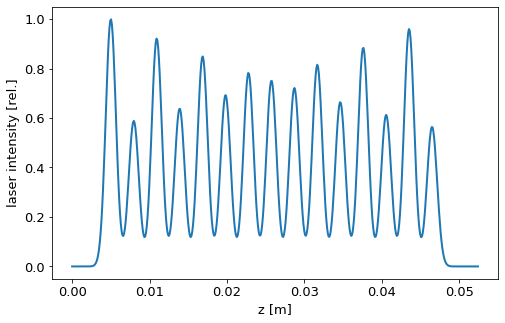

In [37]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_z, gaussian_amp(_z[:,np.newaxis], amplitudes[np.newaxis, :], beam_locs[np.newaxis, :], σlaser).sum(axis = 1), lw = 2)

ax.set_xlabel('z [m]')
ax.set_ylabel('laser intensity [rel.]')

set_fontsize(ax, 13)

# Solving the ODE system for rotational cooling with a single laser and detuning
## Loading Julia

In [38]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using BenchmarkTools""")
Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())
""")

<PyCall.jlwrap Logging.ConsoleLogger(Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000834) open, 0 bytes waiting), Info, Logging.default_metafmt, true, 0, Dict{Any,Int64}())>

In [39]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [40]:
Main.eval("""
function gaussian(x::Float64, a::Float64, μ::Float64, σ::Float64)::Float64
    a.*exp(.-(x.-μ).^2 ./ (2 .* σ.*σ))
end
""")

<PyCall.jlwrap gaussian>

In [41]:
Main.eval("""
function multipass_intensity(x::Float64, amplitudes, locations, σ::Float64)::Float64
    intensity::Float64 = 0.0
    for i = 1:length(amplitudes)
        @inbounds intensity += gaussian(x,amplitudes[i], locations[i], σ)
    end
    return intensity
end
""")

<PyCall.jlwrap multipass_intensity>

In [42]:
Main.eval("""
function phase_modulation(t::Float64, β::Float64, ω::Float64)
    return exp(1im.*β.*sin(ω.*t))
end
""")

<PyCall.jlwrap phase_modulation>

### Verifying Julia multipass and phase modulation functions

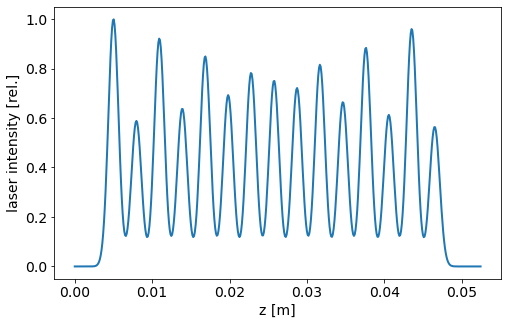

In [43]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_z, [Main.multipass_intensity(zi, amplitudes, beam_locs, σlaser) for zi in _z], lw = 2)

ax.set_xlabel('z [m]')
ax.set_ylabel('laser intensity [rel.]')

set_fontsize(ax, 14)

In [44]:
Main.amplitudes = amplitudes
Main.beam_locs = beam_locs

Main.eval("""
@btime multipass_intensity(1e-6,amplitudes,beam_locs,5e-3)
""")

0.873503968557283

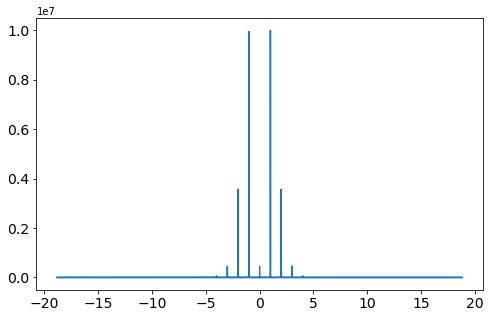

In [45]:
Γ = 1/(100e-9)
β = 2.2
ωphase = Γ # 1.6 MHz

t = np.linspace(0,100e-6, 6001)
s = [Main.phase_modulation(ti,β,ωphase) for ti in t]

fourier_transform = np.fft.fft(s)
fftfreq = np.fft.fftfreq(len(fourier_transform), np.diff(t)[0])

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(fftfreq*2*np.pi/Γ, np.abs(fourier_transform**2))
set_fontsize(ax, 14)

In [46]:
Main.eval("""
@btime phase_modulation(1e-6,2.2,2*pi*1.6e6)
""")

(0.274114460062896-0.9616970743349628j)

## Loading the ODE function

In [47]:
# reading from file
with open('ode_fun.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [48]:
print(ode_fun[:179])


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω = p[1]
		Ωᶜ = conj(Ω)
		νp = p[2]
		Δ = p[3]
		Px = square_wave(t, νp, 3.141592653589793)
		Pz = square_wave(t, νp, 0.0) 


In [49]:
ode_fun_new = """
function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tνp = p[2]
\t\tΔ = p[3]
\t\tv = p[4]
\t\tσlaser = p[5]
\t\tβ = p[6]
\t\tωphase = p[7]
\t\tn_passes = floor(Int8,p[8])
\t\tΩ = p[1].*multipass_intensity(v.*t, p[9:9+n_passes], p[9+n_passes:end], σlaser) .* phase_modulation(t, β, ωphase)
\t\tΩᶜ = conj(Ω)
\t\tPx = square_wave(t, νp, 3.141592653589793)
\t\tPz = square_wave(t, νp, 0.0)
"""

In [50]:
ode_fun_new += ode_fun[179:]
print(ode_fun_new[:1116])


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		νp = p[2]
		Δ = p[3]
		v = p[4]
		σlaser = p[5]
		β = p[6]
		ωphase = p[7]
		n_passes = floor(Int8,p[8])
		Ω = p[1].*multipass_intensity(v.*t, p[9:9+n_passes], p[9+n_passes:end], σlaser) .* phase_modulation(t, β, ωphase)
		Ωᶜ = conj(Ω)
		Px = square_wave(t, νp, 3.141592653589793)
		Pz = square_wave(t, νp, 0.0)
   
		du[1,1] = 3367347.38920463*ρ[37,37] + 3367525.85757619*ρ[38,38] + 3367704.32982946*ρ[39,39]
		du[1,2] = -83545.9813842773*1im*ρ[1,2]
		du[1,3] = -83566.3651428223*1im*ρ[1,3]
		du[1,4] = -83586.7483215332*1im*ρ[1,4]
		du[1,5] = 83783184618.4029*1im*ρ[1,5]
		du[1,6] = 83783324359.4973*1im*ρ[1,6]
		du[1,7] = 83783324348.7985*1im*ρ[1,7]
		du[1,8] = 83783324338.0963*1im*ρ[1,8]
		du[1,9] = 83784429890.3703*1im*ρ[1,9]
		du[1,10] = 83784429890.5489*1im*ρ[1,10]
		du[1,11] = 83784429890.728*1im*ρ[1,11]
		du[1,12] = 83784521261.0184*1im*ρ[1,12]
		du[1,13] = 83784521250.7175*1im*ρ[1,13]
		du[1,14] = 83784521240.416*1im*ρ[1,14]
		d

In [51]:
# defining the function in Julia
Main.eval(ode_fun_new)

<PyCall.jlwrap Lindblad_rhs!>

In [52]:
data_dir = Path('stored_data')

fnames = ['rho_ini']

for fname in fnames:
    if fname == 'rho_ini':
        ρ_ini = np.load(data_dir / (fname + '.npy'))
    else:
        globals()[fname] = np.load(data_dir / (fname + '.npy'))

In [53]:
de_main = -0.39444661382277774 # main dipole transition moment
Γ = 1/(100e-9)
Ω =  4.5*Γ*abs(de_main)
ωp = Γ
νp = ωp/(2*np.pi)
β = 5.0
ωphase = Γ
Δ = -4*Γ

Main.Ω = Ω
Main.νp = νp
Main.Δ = Δ
Main.Γ = Γ
Main.β = β
Main.ωphase = ωphase
Main.σlaser = σlaser

Main.ρ_ini = ρ_ini
Main.v = 200

Main.n_passes = len(amplitudes)
Main.eval("p = [Ω, νp, Δ, v, σlaser, β, ωphase, n_passes]")
Main.eval("append!(p, amplitudes)")
Main.eval("append!(p, beam_locs)")

array([ 1.77500976e+07,  1.59154943e+06, -4.00000000e+07,  2.00000000e+02,
        6.60500000e-04,  5.00000000e+00,  1.00000000e+07,  1.50000000e+01,
        1.00000000e+00,  5.88201367e-01,  9.21600000e-01,  6.38239331e-01,
        8.49346560e-01,  6.92533996e-01,  7.82757790e-01,  7.51447478e-01,
        7.21389579e-01,  8.15372698e-01,  6.64832636e-01,  8.84736000e-01,
        6.12709757e-01,  9.60000000e-01,  5.64673312e-01,  5.00000000e-03,
        7.96333333e-03,  1.09266667e-02,  1.38900000e-02,  1.68533333e-02,
        1.98166667e-02,  2.27800000e-02,  2.57433333e-02,  2.87066667e-02,
        3.16700000e-02,  3.46333333e-02,  3.75966667e-02,  4.05600000e-02,
        4.35233333e-02,  4.64866667e-02])

In [54]:
Main.eval("""
tmp = zeros(ComplexF64,39,39)
Lindblad_rhs!(tmp, ρ_ini, p, 1e-6)
@btime Lindblad_rhs!(tmp, ρ_ini, p, 1e-6)
tmp = 0
""")

0

## Single pass first
Setup a callback to stop solver when it reaches a certain position, in this case the end of the multi pass

In [55]:
Main.eval("""
condition(u,t,integrator) = integrator.p[4]*t > 0.05
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition, affect!)
""")

<PyCall.jlwrap DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, Bool[1, 1])>

In [162]:
Main.eval("p = [Ω, νp, Δ, v, σlaser, 0, ωphase, n_passes]")
Main.eval("append!(p, amplitudes)")
Main.eval("append!(p, beam_locs)")
Main.eval("""
tspan = (0.0f0, 500e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [163]:
Main.eval("""
@time sol = solve(prob,Tsit5(),callback=cb)
tmp = 0
""")

0

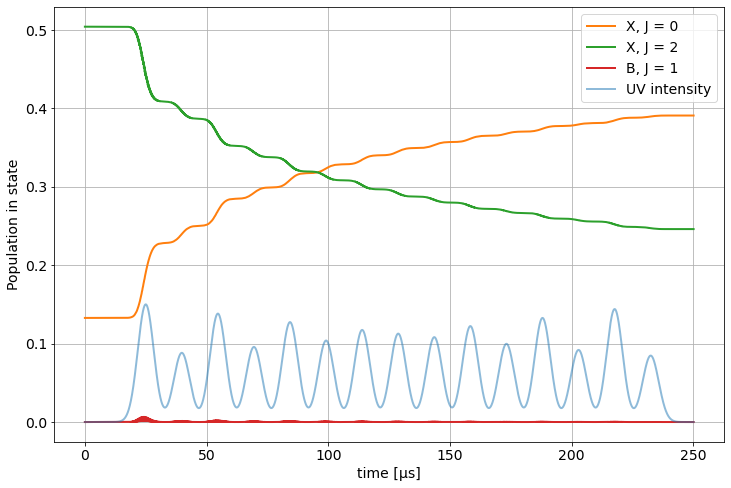

In [164]:
v = Main.v

ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""").copy()

m = t_array < 500e-6
t_array = t_array[m]
pop_results = pop_results[:,m]

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0, label = 'X, J = 0', lw = 2, color = 'C1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2', lw = 2, color = 'C2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1', lw = 2, color = 'C3')


ax.plot(t_array*1e6, [0.15*Main.multipass_intensity(ti*v, amplitudes, beam_locs, σlaser) for ti in t_array], 
        lw = 2, color = 'C0', alpha = 0.5, label = 'UV intensity')

ax.legend(fontsize = 14)
ax.set_xlabel('time [μs]', fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

## Defining a parameter sweep of Ω, Γ and v

Defining the paremeters to sweep over

In [59]:
Main.eval("Omegas = (Ω/4.5)*(1:1:5)")
Main.eval("Deltas = Γ*(-10:.5:10)")
Main.eval("velocities = (124:5:244)")
Main.eval("betas = (2:1:6)")
Main.params = np.array(np.meshgrid(Main.Omegas, Main.Deltas, Main.velocities, Main.betas)).T.reshape(-1,4)

In [60]:
Main.params.shape

(25625, 4)

In [61]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; νp; params[i,2]; params[i,3]; σlaser; params[i,4]; ωphase; n_passes; amplitudes; beam_locs])
end
""")

<PyCall.jlwrap prob_func>

In [62]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.603673728488e9, 1.603673728488e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000834) open, 0 bytes waiting), 0, 0, 0)>

In [63]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [64]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [65]:
# making sure multiple threads are enabled
Main.eval("Threads.nthreads()")

10

In [66]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
# defining a progress bar
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = false, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4, callback = cb)
sim.elapsedTime
""")

4145.8349441

In [67]:
Main.eval("size(params)[1]")

25625

In [69]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [71]:
# putting the results into a single numpy array
results_array = np.zeros([len(ens_u),4+39])

for idx, ((Ω_factor, Δ_factor, v, β), ut_ens) in tqdm(enumerate(zip(Main.params,ens_u)), total = len(ens_u)):
    results_array[idx,:] = [Ω_factor, Δ_factor, v, β] + list(ut_ens)

100%|████████████████████████████████████████████████████████████████████████| 25625/25625 [00:00<00:00, 123040.32it/s]


In [142]:
import logging
# save data to HDF:
with h5py.File("rotational_cooling_laser_only.hdf5", 'a') as f:
    grp = f.create_group("parameter sweep: Ω Δ vz β")
    dset = grp.create_dataset("initial conditions", data = ρ_ini)
    dset = grp.create_dataset("final population", data = results_array)
    grp.attrs['description'] = "Solve ODE for X, J = 0,1,2 and B, J=1 with laser coupling X, J=2 and B, J = 1.\n" +\
                               "Polarization switching between z and x at frequency νp.\n" +\
                               "Multipassed light, assumed uniform intensity in height, gaussian distribution in width with σlaser.\n" +\
                               "Phase modulation at ωphase = Γ, with various β."
    grp.attrs['Γ'] = Γ
    grp.attrs['νp'] = Γ/(2*np.pi)
    grp.attrs['de_main'] = de_main
    grp.attrs['E'] = 0
    grp.attrs['B'] = 0.001
    grp.attrs['ωphase'] = Γ
    grp.attrs['σlaser'] = σlaser
    grp.attrs['beam locations'] = beam_locs
    grp.attrs['beam amplitudes'] = amplitudes
    dset.attrs['column names'] = "Ω, Δ, vz, β, state populations"

In [143]:
# loading results from file
with h5py.File("rotational_cooling_laser_only.hdf5", 'r') as f:
    grp = f['parameter sweep: Ω Δ vz β']
    results_array = grp['final population'][()]
    ρ_ini = grp['initial conditions'][()]
    Γ = grp.attrs['Γ']
    de_main = grp.attrs['de_main']

In [144]:
# for making Ω slices I round Ω_factor to two digits to preven any floating point issues
# keep in mind when the desired spacing is less than two digits to remove rounding or 
# increase the digits
results_array_J0 = np.zeros([len(results_array),5])
for idx, (Ω_factor, Δ_factor, v, β_factor, *pops) in tqdm(enumerate(results_array), total = len(ens_u)):
    results_array_J0[idx,:] = [round(Ω_factor/Γ/abs(de_main),2), Δ_factor/Γ, v, β_factor, np.sum(pops[:4])]

100%|█████████████████████████████████████████████████████████████████████████| 25625/25625 [00:00<00:00, 54805.21it/s]


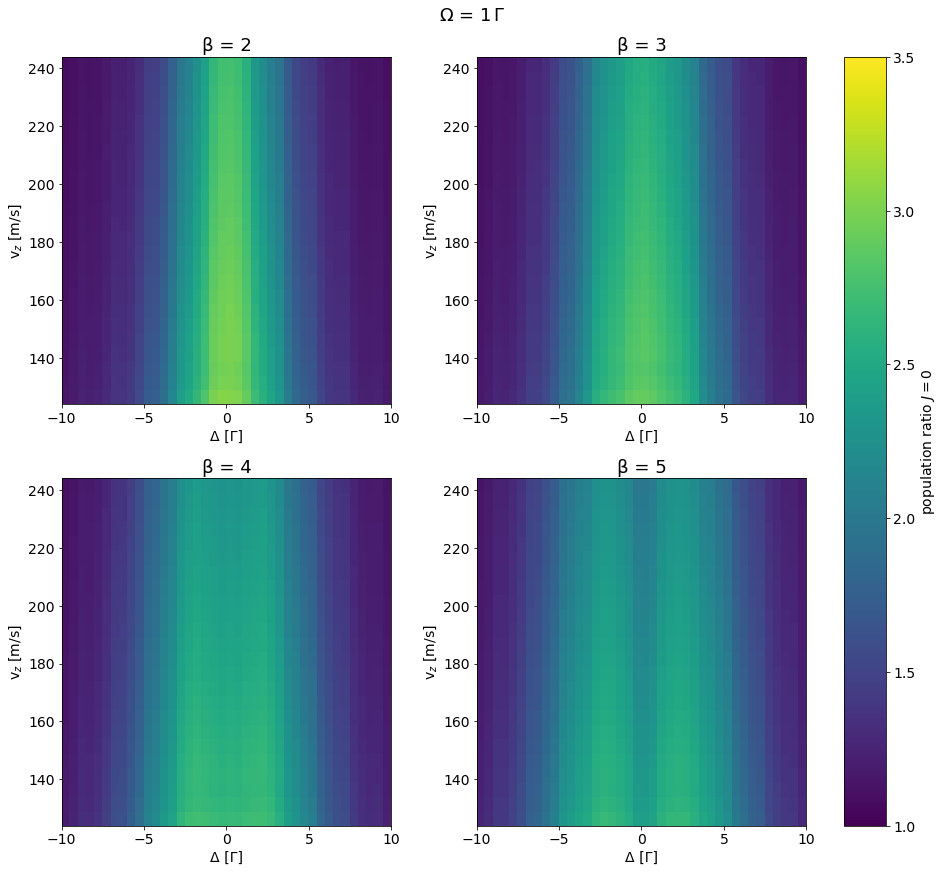

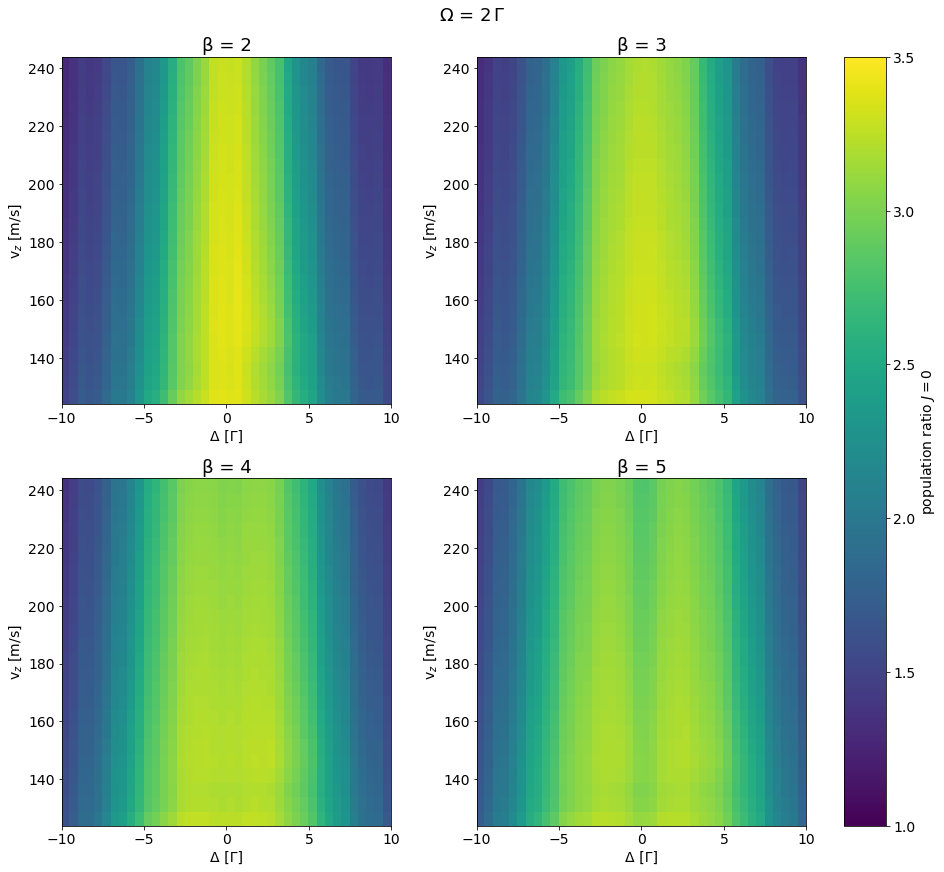

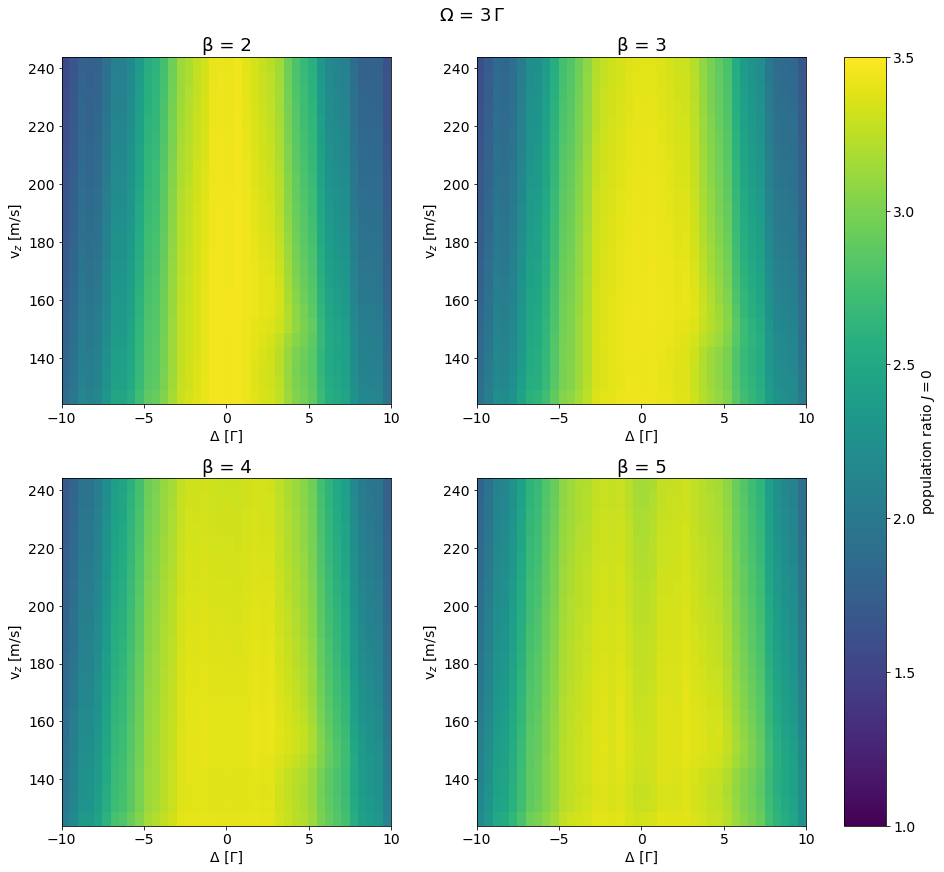

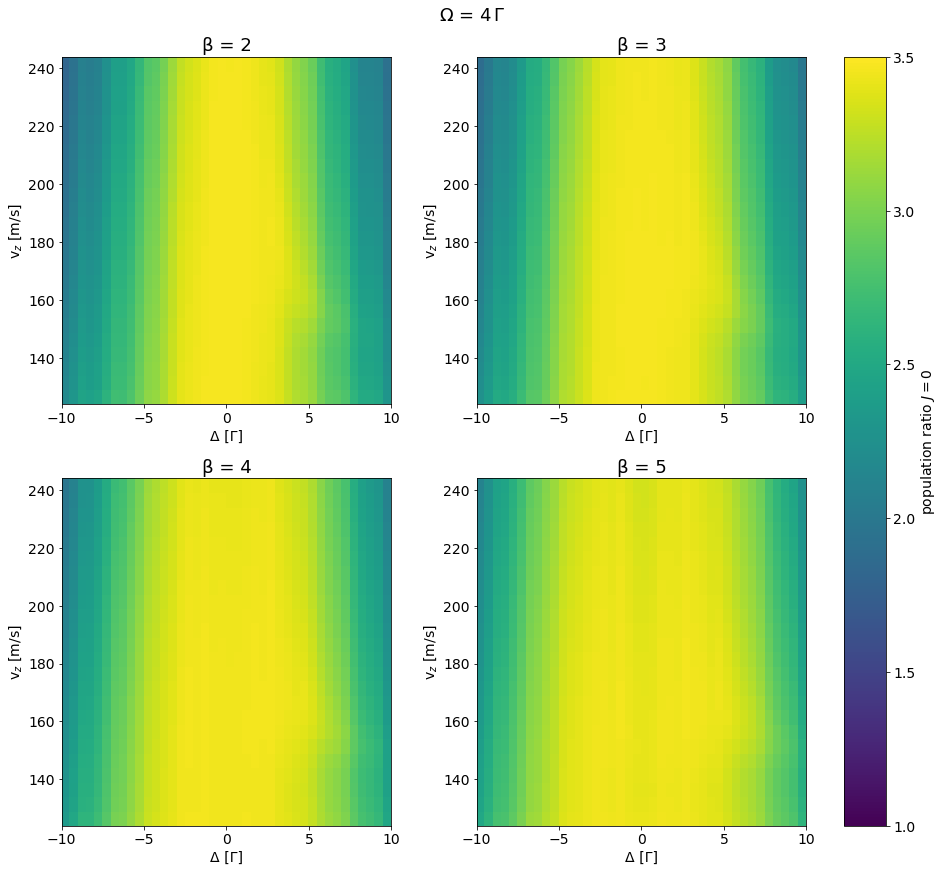

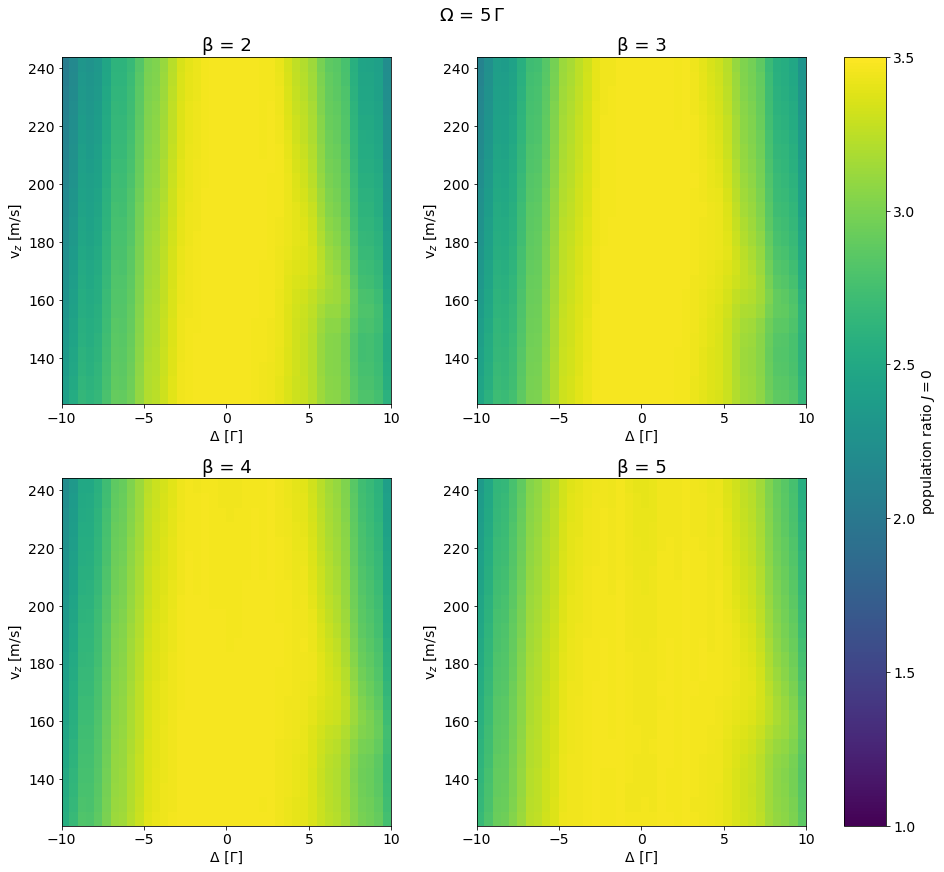

In [150]:
P0_ini = np.diag(ρ_ini[:4,:4]).sum().real
vmin, vmax = 1.0, 3.5

# selecting Ω slices
for Ω_factor in [1,2,3,4,5]:
    fig, axes = plt.subplots(2,2, figsize = (13,12), constrained_layout=True)
    
    fig.suptitle(f'Ω = {Ω_factor}$\,$Γ', fontsize = 18)
    axes = axes.flatten()
    
    # selecting β slices
    for idx, β_factor in enumerate([2,3,4,5]):
        m = results_array_J0[:,0] == Ω_factor
        m &= results_array_J0[:,3] == β_factor
        data_slice = np.s_[:,[1,2,4]]
        _array = results_array_J0[m][data_slice]

        dim_x, dim_y = len(Main.Deltas), len(Main.velocities)
        x,y,z = _array.T

        # Set up a regular grid of interpolation points
        X, Y = np.linspace(x.min(), x.max(), dim_x), np.linspace(y.min(), y.max(), dim_y)
        X, Y = np.meshgrid(X,Y)

        # Interpolate; there's also method='cubic' for 2-D data such as here
        Z = griddata((x, y), z, (X, Y), method='nearest')/P0_ini

        cs = axes[idx].pcolormesh(X,Y,Z, shading = 'nearest', vmin = vmin, vmax = vmax)


        axes[idx].set_xlabel("Δ [Γ]")
        axes[idx].set_ylabel(r"v$_z$ [m/s]")
        axes[idx].set_title(f'β = {β_factor}')

        set_fontsize(axes[idx], 14)
        
    cbar = fig.colorbar(cs, ax=axes.ravel().tolist())
    cbar.set_label('population ratio $J=0$')
    set_fontsize(cbar.ax, 14)

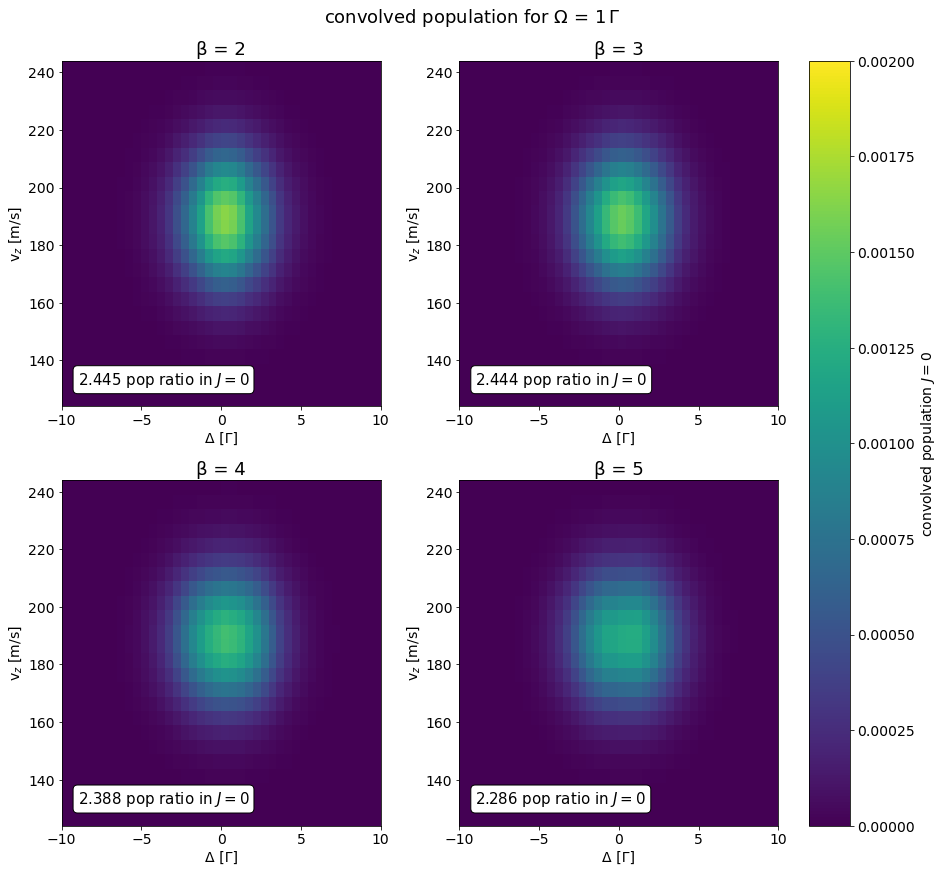

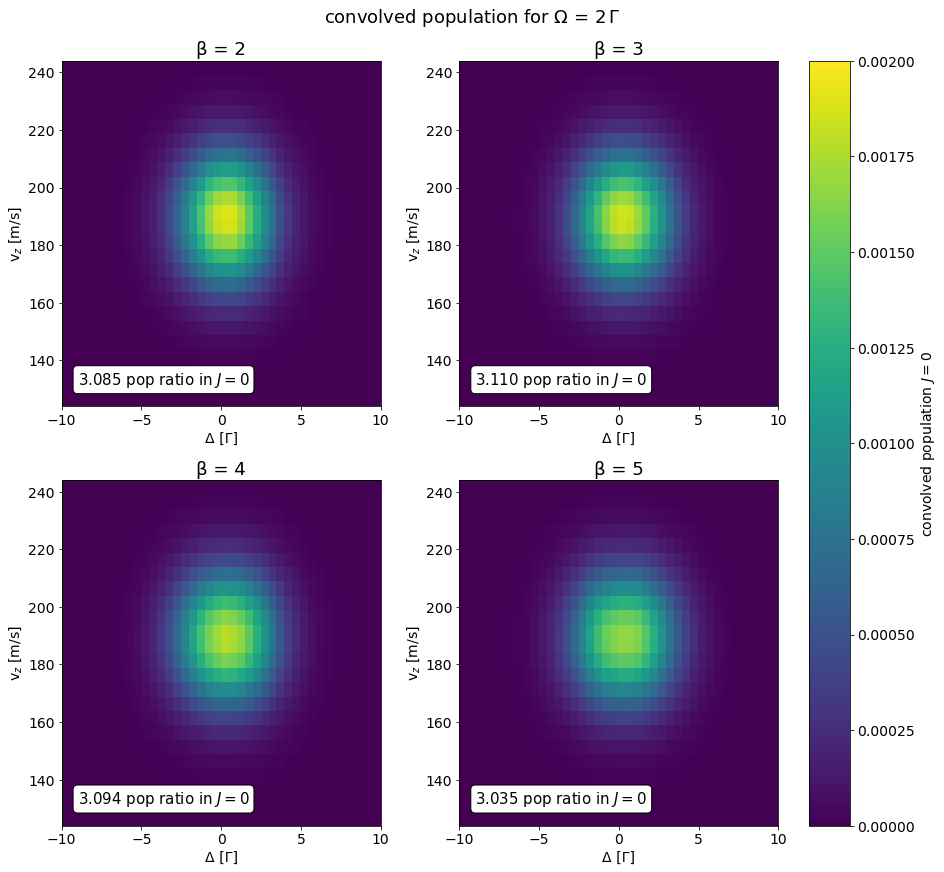

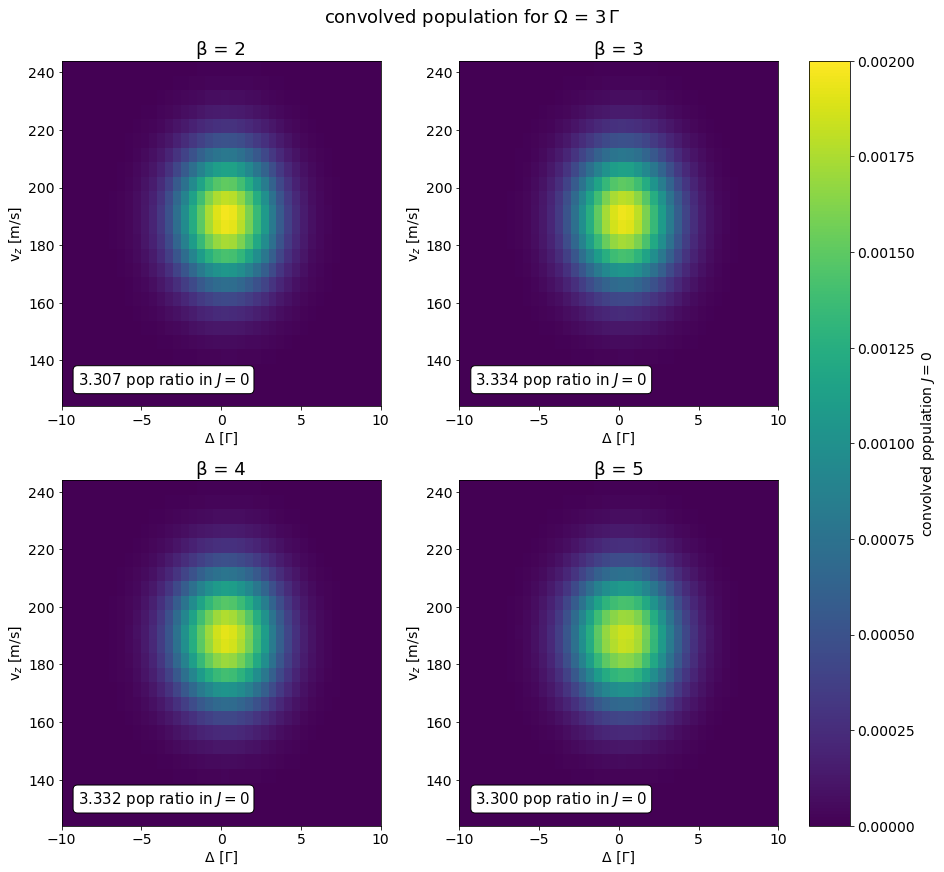

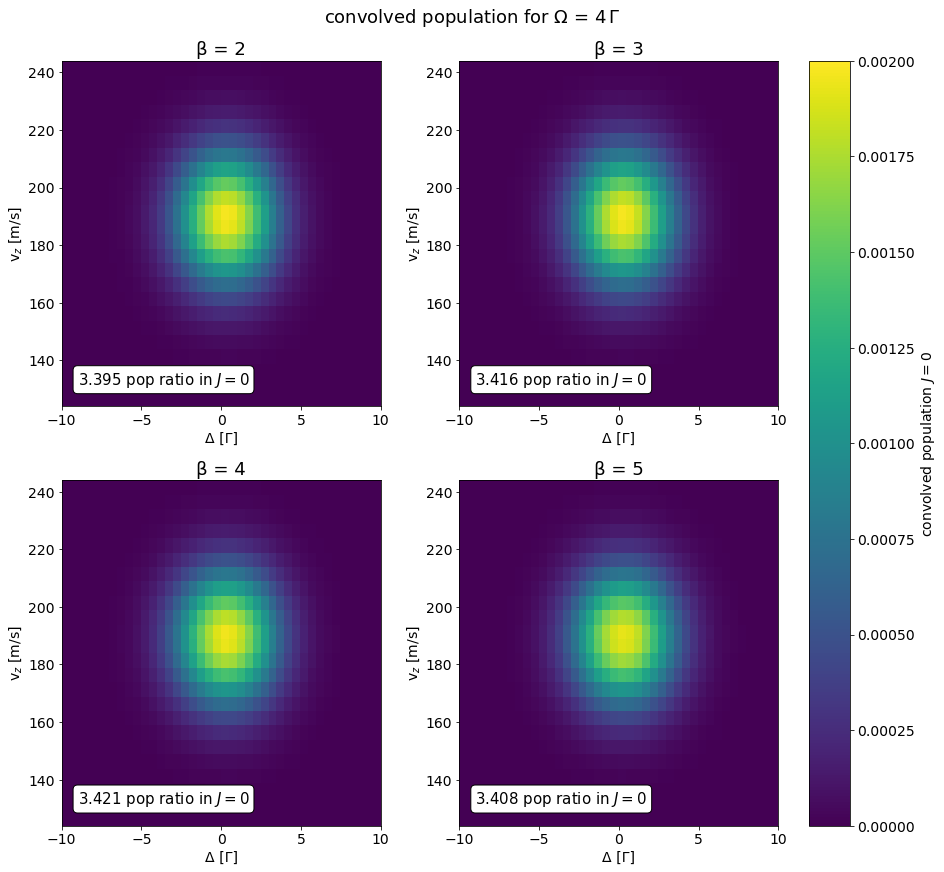

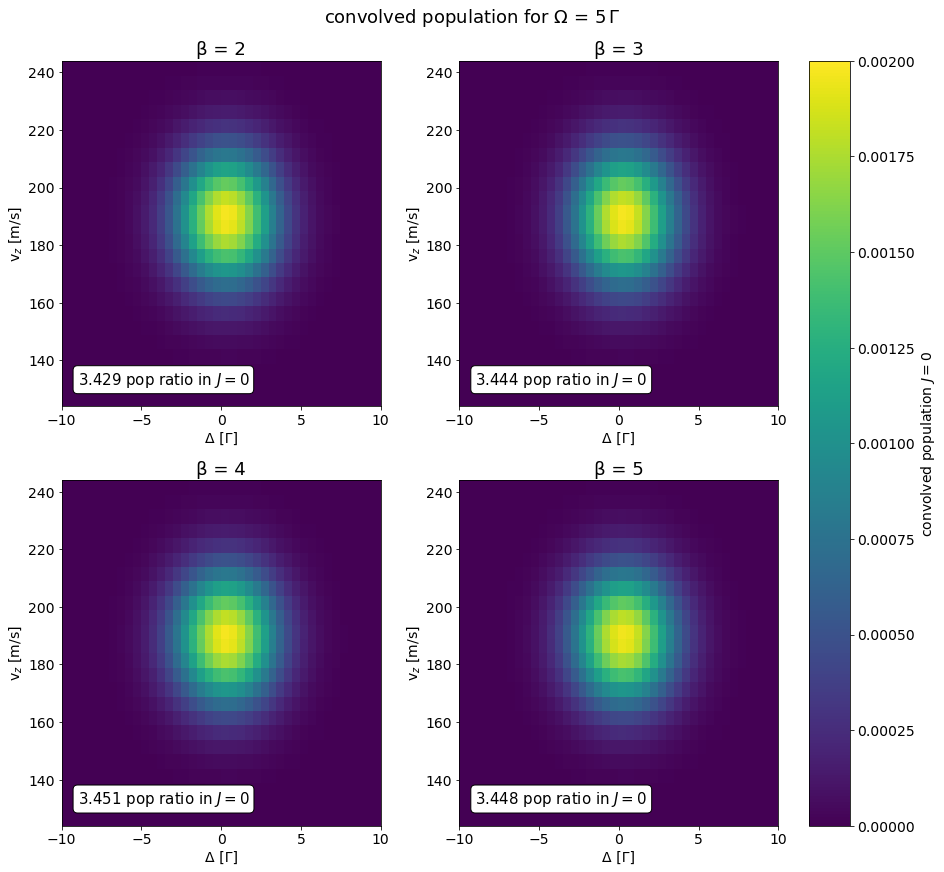

In [152]:
 # check that the data is within this range, used to use same colorscale for each figure
vmin, vmax = 0,0.002

# selecting Ω slices
for Ω_factor in [1,2,3,4,5]:
    fig, axes = plt.subplots(2,2, figsize = (13,12), constrained_layout=True)
    
    fig.suptitle(f'convolved population for Ω = {Ω_factor}$\,$Γ', fontsize = 18)
    axes = axes.flatten()
    # selecting β slices
    for idx, β_factor in enumerate([2,3,4,5]):
        m = results_array_J0[:,0] == Ω_factor
        m &= results_array_J0[:,3] == β_factor
        data_slice = np.s_[:,[1,2,4]]
        _array = results_array_J0[m][data_slice]

        dim_x, dim_y = len(Main.Deltas), len(Main.velocities)
        x,y,z = _array.T

        # Set up a regular grid of interpolation points
        X, Y = np.linspace(x.min(), x.max(), dim_x), np.linspace(y.min(), y.max(), dim_y)
        X, Y = np.meshgrid(X,Y)

        # Interpolate; there's also method='cubic' for 2-D data such as here
        Z = griddata((x, y), z, (X, Y), method='nearest')

        Δs = X[0,:]
        vs = Y[:,0]
        dΔ = np.diff(Δs)[0]
        dv = np.diff(vs)[0]

        # convolve with velocity distribution and detuning distribution (from transverse velocities)
        convolve = norm.pdf(vs, mu_z, sigma_z)[:,np.newaxis]*Z
        convolve *= norm.pdf(Δs, mu, sigma)[np.newaxis,:]

        total = (convolve.sum(axis = 0)*dv).sum()*dΔ
        
        cs = axes[idx].pcolormesh(X,Y,convolve, shading = 'nearest', vmin = vmin, vmax = vmax)


        axes[idx].set_xlabel("Δ [Γ]")
        axes[idx].set_ylabel(r"v$_z$ [m/s]")
        axes[idx].set_title(f'β = {β_factor}')

        props = dict(boxstyle='round', facecolor='white', alpha=1)
        text = f"{total/P0_ini:.3f} pop ratio in $J=0$"
        axes[idx].text(0.05, 0.05, text, transform = axes[idx].transAxes, fontsize = 15, bbox = props,
                va = 'bottom', ha = 'left')
        
        set_fontsize(axes[idx], 14)
        
    cbar = fig.colorbar(cs, ax=axes.ravel().tolist())
    cbar.set_label('convolved population $J=0$')
    set_fontsize(cbar.ax, 14)